Analyze the site data in the cleaned data to determine statistical properties and distributions of this data 

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


                  RE           site  \
0         M.Aac9709I           GATC   
1           M.AacDam           GATC   
2         M.AalSMS7I         TGAATC   
3        M.AalSMS7II    AGCNNNNRTCA   
4        S.AalSMS7II    AGCNNNNRTCA   
...              ...            ...   
11425       M.ZmoIII          GANTC   
11426    M.Zmo29192I  ACANNNNNNRTGG   
11427    S.Zmo29192I  ACANNNNNNRTGG   
11428   M.Zmo29192II         GATATC   
11429  M.Zmo29192III          GANTC   

                                                sequence  siteLen  seqLen  
0      MPEPAKPATPAKSRPFLKWAGGKYRLMDEINRLLPKRKQCLVEPFV...        4     284  
1      MPEPAKPATPAKSRPFLKWAGGKYRLMDEINRLLPKRKQCLVEPFV...        4     284  
2      MSKEKETTENPMEKVQSHDWNKERLEQLKQLMPDLFTNDGALNINE...        6     659  
3      MAKKTTTKEKSIEESLWDAANKLRGSIEPSEYKHVVLGLIFLKFAS...       11     521  
4      MQSNYRPIGDYIQLVDERNVDLQVTTLLGLSISKQFIHSVANTVGT...       11     417  
...                                                  ...      ...     ...  

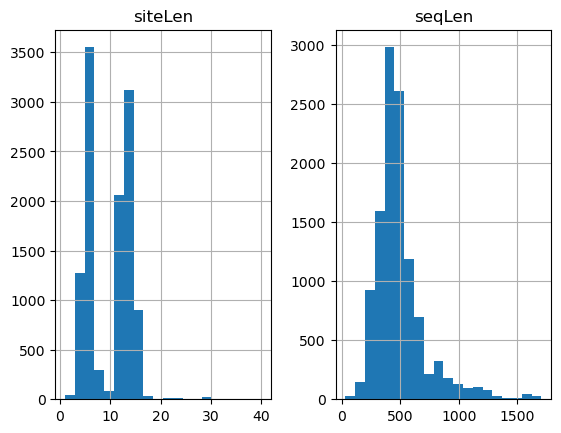

In [3]:
# read data and add length columns

dataDir = '/home/allen/projects/DATA/bsp'
csvFile = 'protein_seqs_cleaned.csv'

dataDf = pd.read_csv( os.path.join( dataDir, csvFile ) )
dataDf['siteLen'] = dataDf['site'].map( lambda x: len(x) )
dataDf['seqLen'] = dataDf['sequence'].map( lambda x: len(x) )

print(dataDf)
print(dataDf.describe())
dataDf.hist(bins=20)
print('unique sequences:', len(set(dataDf.sequence)) )
print('unique sites:', len(set(dataDf.site)) )

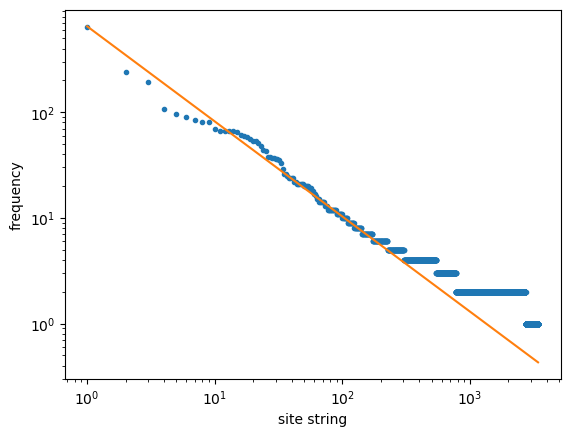

In [4]:
# frequency of site sequences

# count site strings and order 
siteCounts=list(dataDf.site.value_counts())
siteCounts.sort()
siteCounts.reverse()

# a manual fit power law
xx = np.arange(1,len(siteCounts)+1 )
yy = 650/xx**0.9

plt.figure(0)
plt.ylabel('frequency')
plt.xlabel('site string')
plt.loglog(xx,siteCounts,'.')
plt.loglog(xx,yy)


character set: ['A', 'C', 'G', 'T', 'N', 'B', 'D', 'H', 'K', 'M', 'R', 'S', 'V', 'W', 'Y']
total number of characters: 109931


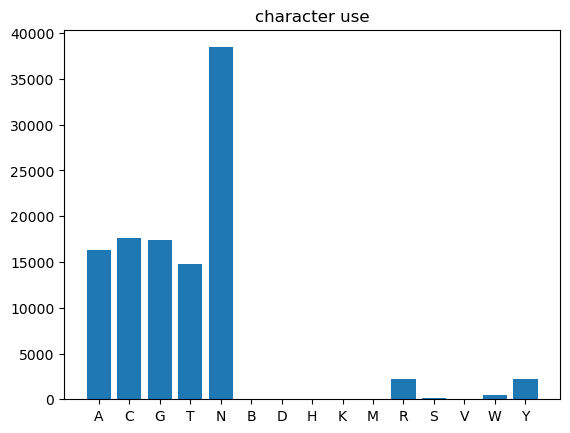

In [6]:
# character use

# now create character use list, print
sitesConcat = ''.join(dataDf.site)
charList = list( set( sitesConcat ).difference({'A','C','G','T','N'}) )
charList.sort()
charList = ['A','C','G','T','N'] + charList
print( '\ncharacter set:', charList )

# count character use and plot
charCounts = []
for c in charList:
    charCounts.append( sitesConcat.count(c) )
plt.figure(2)
plt.title('character use')
plt.bar(range(len(charCounts)),charCounts,tick_label=charList) 
print('total number of characters:', sum(charCounts) )


character set: ['A', 'C', 'G', 'T', 'N', 'X']
total number of character: 109931


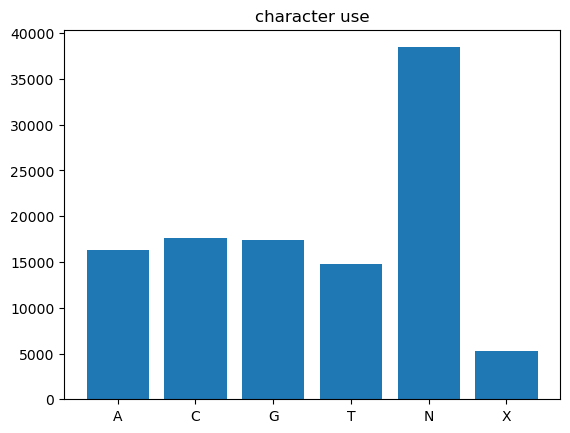

In [7]:
# to simplify analysis, replace ambiguous characters (except for N) with X,
# and recalculate character use

dataDf['site'] = dataDf['site'].str.replace('[BDHKMRSVWY]', 'X', regex=True)

# now re-create character use list, print
sitesConcat = ''.join(dataDf.site)
charList = list( set( sitesConcat ).difference({'A','C','G','T','N'}) )
charList.sort()
charList = ['A','C','G','T','N'] + charList
print( '\ncharacter set:', charList )

# re-count character use and plot
charCounts = []
for c in charList:
    charCounts.append( sitesConcat.count(c) )
plt.figure(2)
plt.title('character use')
plt.bar(range(len(charCounts)),charCounts,tick_label=charList) 
print('total number of character:', sum(charCounts) )

In [8]:
# THIS PART STARTS THE UNSUPERVISED MACHINE LEARNING ANALYSIS

# START WITH t-SNE PLOT OF UNIQUE SEQUENCES
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances  

# Extract unique sequences
unique_sites = dataDf['site'].unique()
print(f"Total entries: {len(dataDf)}")
print(f"Unique sites: {len(unique_sites)}")

Total entries: 11430
Unique sites: 3376


In [9]:
# DEFINE Function to calculate edit distance between two sequences
# USE THE NORMALIZED LEVENSHTEIN DISTANCE
# (claude opus 4.1 output)

def sequence_distance(seq1, seq2):
    """
    Calculate normalized edit distance between two sequences.
    Uses Levenshtein distance normalized by the length of the longer sequence.
    """
    len1, len2 = len(seq1), len(seq2)
    
    # Create distance matrix
    d = np.zeros((len1 + 1, len2 + 1))
    
    # Initialize first column and row
    for i in range(len1 + 1):
        d[i][0] = i
    for j in range(len2 + 1):
        d[0][j] = j
    
    # Fill in the rest of the matrix
    for i in range(1, len1 + 1):
        for j in range(1, len2 + 1):
            if seq1[i-1] == seq2[j-1]:
                cost = 0
            else:
                cost = 1
            d[i][j] = min(
                d[i-1][j] + 1,      # deletion
                d[i][j-1] + 1,      # insertion
                d[i-1][j-1] + cost  # substitution
            )
    
    # Normalize by the length of the longer sequence
    return d[len1][len2] / max(len1, len2)

In [124]:
# Create distance matrix for all unique sequences
n_unique = len(unique_sites)
distance_matrix = np.zeros((n_unique, n_unique))

print("Calculating pairwise distances...")
for i in range(n_unique):
    if i % 100 == 0:
        print(f"Progress: {i}/{n_unique}")
    for j in range(i+1, n_unique):
        dist = sequence_distance(unique_sites[i], unique_sites[j])
        distance_matrix[i][j] = dist
        distance_matrix[j][i] = dist
print("...done")

Calculating pairwise distances...
Progress: 0/3376
Progress: 100/3376
Progress: 200/3376
Progress: 300/3376
Progress: 400/3376
Progress: 500/3376
Progress: 600/3376
Progress: 700/3376
Progress: 800/3376
Progress: 900/3376
Progress: 1000/3376
Progress: 1100/3376
Progress: 1200/3376
Progress: 1300/3376
Progress: 1400/3376
Progress: 1500/3376
Progress: 1600/3376
Progress: 1700/3376
Progress: 1800/3376
Progress: 1900/3376
Progress: 2000/3376
Progress: 2100/3376
Progress: 2200/3376
Progress: 2300/3376
Progress: 2400/3376
Progress: 2500/3376
Progress: 2600/3376
Progress: 2700/3376
Progress: 2800/3376
Progress: 2900/3376
Progress: 3000/3376
Progress: 3100/3376
Progress: 3200/3376
Progress: 3300/3376


In [ ]:
print("Running t-SNE...")
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, metric='precomputed', 
            perplexity=30, n_iter=1000, init='random')
tsne_results = tsne.fit_transform(distance_matrix)

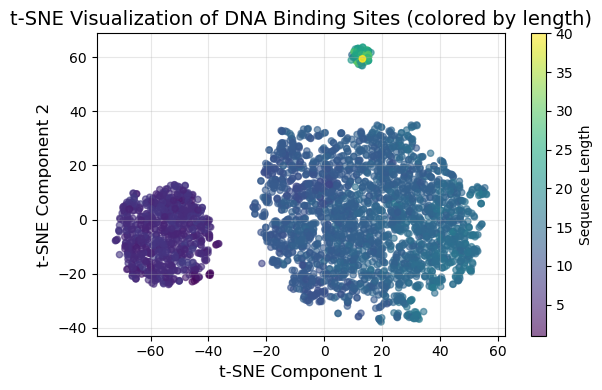

t-SNE embedding complete. Shape: (3376, 2)


In [176]:
# Create the plot
'''
plt.figure(figsize=(6, 4))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.6, s=20)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.title('t-SNE Visualization of DNA Binding Sites', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
'''

# Optional: Color by sequence length
plt.figure(figsize=(6, 4))
lengths = np.array([len(seq) for seq in unique_sites])
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], 
                     c=lengths, cmap='viridis', alpha=0.6, s=20)
plt.colorbar(scatter, label='Sequence Length')
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.title('t-SNE Visualization of DNA Binding Sites (colored by length)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"t-SNE embedding complete. Shape: {tsne_results.shape}")

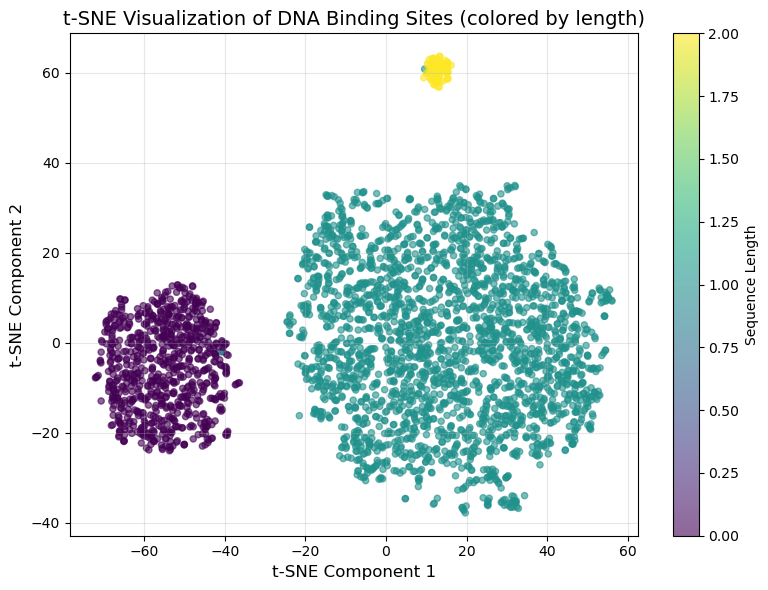

t-SNE embedding complete. Shape: (3376, 2)


In [182]:
def sort_length(s,a,b):
    if len(s)<a:
        return 0
    elif len(s) < b:
        return 1
    else:
        return 2
lengthCat = np.array([sort_length(seq, 9, 18) for seq in unique_sites])

# Optional: Color by sequence length
plt.figure(figsize=(8, 6))
lengths = np.array([len(seq) for seq in unique_sites])
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], 
                     c=lengthCat, cmap='viridis', alpha=0.6, s=20)
plt.colorbar(scatter, label='Sequence Length')
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.title('t-SNE Visualization of DNA Binding Sites (colored by length)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"t-SNE embedding complete. Shape: {tsne_results.shape}")

In [184]:
unique_sites

array(['GATC', 'TGAATC', 'AGCNNNNXTCA', ..., 'GGCAGG', 'AGGAAG',
       'GAGNNNNNNNTTCC'], dtype=object)

In [228]:
# now sort out by lengths
mask0 = np.array([l==0  for l in lengthCat])
uniqueSites0=unique_sites[ mask0 ]
mmask0 = np.outer(mask0,mask0)
distanceMatrix0 = distance_matrix[mmask0].reshape( ( len(uniqueSites0),len(uniqueSites0)))


In [230]:
distanceMatrix0.shape

(774, 774)

Running t-SNE...


/home/allen/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


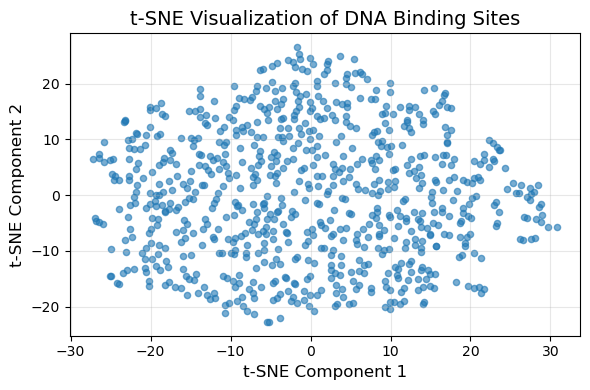

In [234]:
print("Running t-SNE...")
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, metric='precomputed', 
            perplexity=30, n_iter=1000, init='random')
tsne_results = tsne.fit_transform(distanceMatrix0)
plt.figure(figsize=(6, 4))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.6, s=20)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.title('t-SNE Visualization of DNA Binding Sites', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Running t-SNE...


/home/allen/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


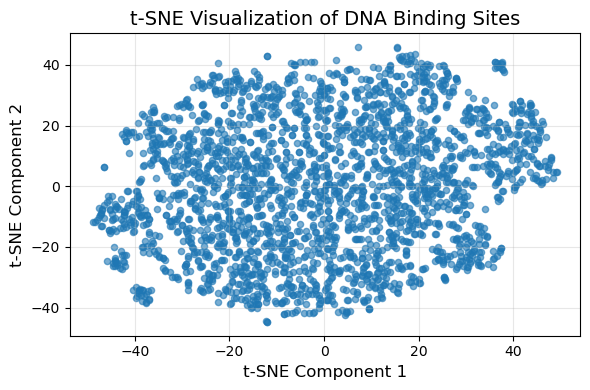

In [238]:
# now sort out by lengths
mask1 = np.array([l==1  for l in lengthCat])
uniqueSites1=unique_sites[ mask1 ]
mmask1 = np.outer(mask1,mask1)
distanceMatrix1 = distance_matrix[mmask1].reshape( ( len(uniqueSites1),len(uniqueSites1)))
print("Running t-SNE...")
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, metric='precomputed', 
            perplexity=30, n_iter=1000, init='random')
tsne_results = tsne.fit_transform(distanceMatrix1)
plt.figure(figsize=(6, 4))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.6, s=20)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.title('t-SNE Visualization of DNA Binding Sites', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Running t-SNE...


/home/allen/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


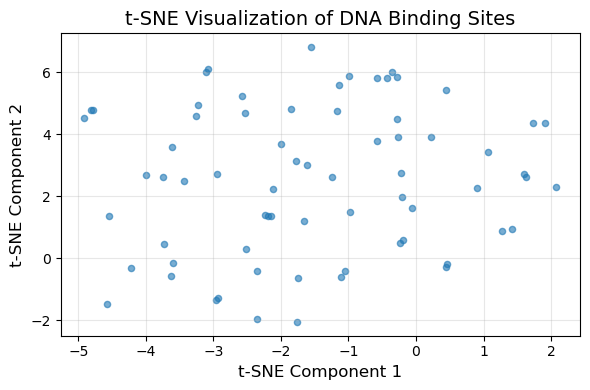

In [240]:
# now sort out by lengths
mask2 = np.array([l==2  for l in lengthCat])
uniqueSites2=unique_sites[ mask2 ]
mmask2 = np.outer(mask2,mask2)
distanceMatrix2 = distance_matrix[mmask2].reshape( ( len(uniqueSites2),len(uniqueSites2)))
print("Running t-SNE...")
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, metric='precomputed', 
            perplexity=30, n_iter=1000, init='random')
tsne_results = tsne.fit_transform(distanceMatrix2)
plt.figure(figsize=(6, 4))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.6, s=20)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.title('t-SNE Visualization of DNA Binding Sites', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


character set: ['A', 'C', 'G', 'T', 'N', 'X']
total number of character: 4549


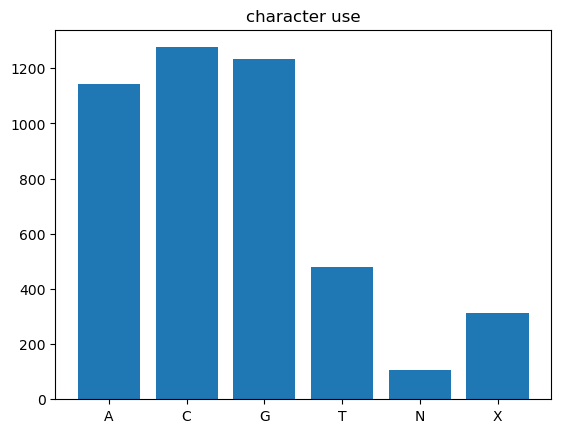

In [258]:
# now create character use list, print
sitesConcat = ''.join(uniqueSites0)
charList = list( set( sitesConcat ).difference({'A','C','G','T','N'}) )
charList.sort()
charList = ['A','C','G','T','N'] + charList
print( '\ncharacter set:', charList )

# how many sites contain each characters

charCounts = []
for c in charList:
    charCounts.append( sitesConcat.count(c) )
plt.figure(2)
plt.title('character use')
plt.bar(range(len(charCounts)),charCounts,tick_label=charList) 
print('total number of character:', sum(charCounts) )


character set: ['A', 'C', 'G', 'T', 'N', 'X']
total number of character: 33257


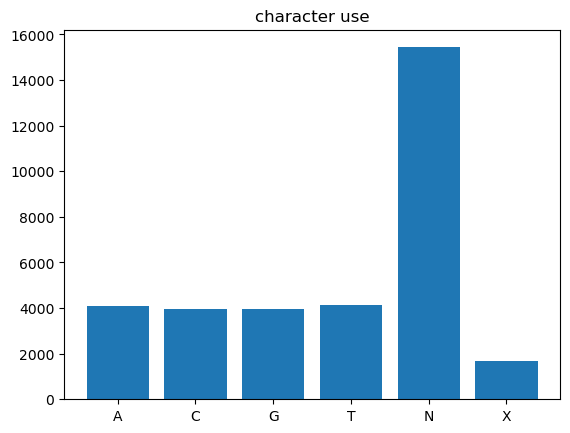

In [260]:
# now create character use list, print
sitesConcat = ''.join(uniqueSites1)
charList = list( set( sitesConcat ).difference({'A','C','G','T','N'}) )
charList.sort()
c
harList = ['A','C','G','T','N'] + charList
print( '\ncharacter set:', charList )

# how many sites contain each characters

charCounts = []
for c in charList:
    charCounts.append( sitesConcat.count(c) )
plt.figure(2)
plt.title('character use')
plt.bar(range(len(charCounts)),charCounts,tick_label=charList) 
print('total number of character:', sum(charCounts) )


character set: ['A', 'C', 'G', 'T', 'N', 'X']
total number of character: 1856


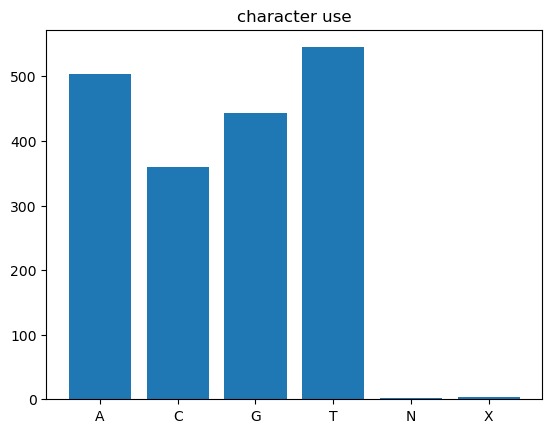

In [262]:
# now create character use list, print
sitesConcat = ''.join(uniqueSites2)
charList = list( set( sitesConcat ).difference({'A','C','G','T','N'}) )
charList.sort()
charList = ['A','C','G','T','N'] + charList
print( '\ncharacter set:', charList )

# how many sites contain each characters

charCounts = []
for c in charList:
    charCounts.append( sitesConcat.count(c) )
plt.figure(2)
plt.title('character use')
plt.bar(range(len(charCounts)),charCounts,tick_label=charList) 
print('total number of character:', sum(charCounts) )

In [1]:
distance_matrix

NameError: name 'distance_matrix' is not defined

In [16]:

data0 = dataDf[ dataDf.site.map( lambda x: len(x) <9) ]
data1 = dataDf[ dataDf.site.map( lambda x: len(x) < 18 and len(x) > 8 ) ]
data2 = dataDf[ dataDf.site.map( lambda x: len(x) > 17 ) ]
print( 'group 0:', len(data0), 'entries. unique:', len(data0.site.unique()) )
print( 'group 1:', len(data1), 'entries. unique:', len(data1.site.unique()) )
print( 'group 2:', len(data2), 'entries. unique:', len(data2.site.unique()) )

group 0: 5163 entries. unique: 774
group 1: 6191 entries. unique: 2533
group 2: 76 entries. unique: 69


In [20]:
data2.site.unique()

array(['TGGGGAGGTTTTTCAGTATC', 'ACTCATAGTCCGTGGACTTATCGA',
       'TTGAGGAGGTTTCTCTGTAAATAA',
       'GTTGCAGGCAATATCCGGCGTAGTGCCGGAATGCGTCAG',
       'ACTTATAGTCTGTAGCCTATAGTC', 'AACGCTCAGCAATTCCCACGT',
       'TGGGAAAAAGCCAGTGGGTTCGAAGAGTCTATG', 'ACTTAAAGTCTGTAGACTTATAGC',
       'ACTTATAGTCCGTGGACACATAGT', 'GAGTAAGAGCCCGTAGTAATGACATGGC',
       'ATTATCCGTGATGAGTCAATTCA',
       'ATGTAAACTCACGCTTCGGTGATCCAAACGTGACAACTG',
       'TAACTATAACGGTCCTAAGGTAGCGAA', 'GAAGGTTTGGCACCTCGATGTCGGCTCATC',
       'CGATCCTAAGGTAGCGAAATTCA', 'CCCGGCTAACTCTGTGCCAG',
       'CTGGGTTCAAAACGTCGTGAGACAGTTTGG', 'GTACTAGCATGGGGTCAAATGTCTTTCTGG',
       'ACACTAAGGAAAACTTAGTAA', 'TTTTTTGGTCATCCAGAAGTATAT',
       'ATGCCTTGCCGGGTAAGTTCCGGCGCGCAT',
       'GTACATGGCATGGGTACATGATGAAATCCAAGTAGGCTGC',
       'TGGCGACGAAAACCGCTTGGAAAGTGGCTG', 'ACCTACCATTAACGGAGTCAAAGGCCATTG',
       'TAGGTACTGGACTTAAAATTCAGGTTTTGT',
       'ATGTGACTTATAGTCCGTGTGATTATAGTCAACAT', 'TTTTCCTGTATATGACTTAAAT',
       'GCCCCTCATAACCCGTATCA

In [21]:
data0.RE

0           M.Aac9709I
1             M.AacDam
2           M.AalSMS7I
10         M.Aam10684I
11          Aam10684II
             ...      
11417        Yru10476I
11420       M.ZalSM2II
11425         M.ZmoIII
11428     M.Zmo29192II
11429    M.Zmo29192III
Name: RE, Length: 5163, dtype: object

In [24]:
data2.to_csv('data2.csv')